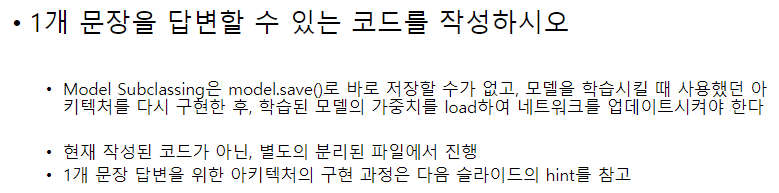

In [1]:
example_text = "하루가 또 가네요."

In [2]:
path = "c:\\pytest\\data\\transformer\\"
token_file = "transformer.pickle"
model_weights_file = "weights.h5"
sentence_max_length = 8
PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2

MAX_SEQUENCE = 25


In [3]:
import os
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np


KeyboardInterrupt: 

In [ ]:
with open(path+token_file, "rb") as file:
    tokenizer = pickle.load(file)

word_index = tokenizer.word_index
char2idx_dict = word_index
idx2char_dict = {y: x for x, y in word_index.items()}
char2idx_dict['<PAD>'] = 0
char2idx_dict['<SOS>'] = char2idx_dict['SOS']
del char2idx_dict['SOS']
char2idx_dict['<END>'] = char2idx_dict['EOS']
del char2idx_dict['EOS']
idx2char_dict[0] = '<PAD>'
idx2char_dict[1] = '<SOS>'
idx2char_dict[2] = '<END>'

prepro_configs = dict({'char2idx': char2idx_dict, 'idx2char': idx2char_dict, 'vocab_size': len(word_index), 'pad_symbol': '<PAD>', 'std_symbol': '<SOS>', 'end_symbol': '<END>'})
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

kargs = {'model_name': 'transformer', 'num_layers': 2, 'd_model': 512, 'num_heads': 8, 'dff': 2048, 'input_vocab_size': vocab_size, 'target_vocab_size': vocab_size, 'maximum_position_encoding': MAX_SEQUENCE, 'end_token_idx': char2idx[end_index], 'rate': 0.1}

In [ ]:
data = pd.DataFrame([example_text], columns=['A'])
data

,A
0,하루가 또 가네요.


In [ ]:
outputs_input = data.A.apply(lambda x: '<SOS> '+x+' <EOS>')
outputs_target = data.A.apply(lambda x: x+' <EOS>')
encoder_input = tokenizer.texts_to_sequences(list(outputs_input))
decoder_input = tokenizer.texts_to_sequences(list(outputs_target))


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input_pad = pad_sequences(encoder_input, maxlen=sentence_max_length, padding='post')
decoder_input_pad = pad_sequences(decoder_input, maxlen=sentence_max_length, padding='post')

index_inputs = encoder_input_pad
index_outputs = decoder_input_pad


In [ ]:
def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1-tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

def get_angles(pos, i, d_model):
    angle_rates = 1/np.power(10000, (2*i//2)/np.float32(d_model))
    return pos*angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask*-1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super().__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model//self.num_heads
        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])
        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

def feed_forward_network(**kargs):
    return tf.keras.Sequential([tf.keras.layers.Dense(kargs['dff'], activation='relu'), tf.keras.layers.Dense(kargs['d_model'])])


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super().__init__()
        self.mha = MultiHeadAttention(**kargs)
        self.ffn = feed_forward_network(**kargs)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x+attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1+ffn_output)
        return out2


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super().__init__()
        self.d_model = kargs['d_model'] # 512
        self.num_layers = kargs['num_layers'] # 2
        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['input_vocab_size'], output_dim=self.d_model)
        self.pos_encoding = positional_encoding(position=kargs['maximum_position_encoding'], d_model=self.d_model)
        self.enc_layers = [EncoderLayer(**kargs)for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
        return x


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super().__init__()
        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)
        self.ffn = feed_forward_network(**kargs)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1+x)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2+out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output+out2)
        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super().__init__()
        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']
        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['target_vocab_size'], output_dim=self.d_model)
        self.pos_encoding = positional_encoding(position=kargs['maximum_position_encoding'], d_model=self.d_model)
        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x, attention_weights


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super().__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)
        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)
        dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output

    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], axis=0)
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, axis=-1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX]+predict_tokens, axis=0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        return predict_tokens


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [ ]:
def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)
    return tf.reduce_mean(acc)


In [ ]:
model = Transformer(**kargs)
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

In [ ]:
# reconstructed_model = tf.keras.models.(path+model_weights_file)
# model.set_weights(reconstructed_modl)
model.load_weights(path+model_weights_file)

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

In [ ]:
pred = model.inference(index_inputs)

In [ ]:
result=''
for i in pred:
    result+=idx2char_dict[i]+' '
print("Q:",example_text)
print("A:",result)

Q: 하루가 또 가네요.
A: 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 같아 


In [ ]:
model.built = True
model.load_weights(path+model_weights_file)

In [ ]:
pred = model.inference(index_inputs)

In [ ]:
result=''
for i in pred:
    result+=idx2char_dict[i]+' '
print("Q:",example_text)
print("A:",result)

Q: 하루가 또 가네요.
A: 자랑하는 자리니까요 


In [ ]:
user_input = input()
data = pd.DataFrame([user_input], columns=['A'])
outputs_input = data.A.apply(lambda x: '<SOS> '+x+' <EOS>')
encoder_input = tokenizer.texts_to_sequences(list(outputs_input))
encoder_input_pad = pad_sequences(encoder_input, maxlen=sentence_max_length, padding='post')
index_inputs = encoder_input_pad
pred = model.inference(index_inputs)
result=[]
for i in pred:
    result.append(idx2char_dict[i])
result=' '.join(result)+"."
print("Q:",user_input)
print("A:",result)

NameError: name 'pd' is not defined

In [ ]:
def qna(text):
    data = pd.DataFrame([user_input], columns=['A'])
    outputs_input = data.A.apply(lambda x: '<SOS> '+x+' <EOS>')
    encoder_input = tokenizer.texts_to_sequences(list(outputs_input))
    # encoder_input_pad = pad_sequences(encoder_input, maxlen=sentence_max_length, padding='post')
    # index_inputs = encoder_input_pad
    pred = model.inference(np.array(encoder_input))
    result=[]
    for i in pred:
        result.append(idx2char_dict[i])
    return ' '.join(result)+"."
    
user_input = input()
for n in range(1, 7):
    print(f"{n}: {user_input}")
    user_input=qna(user_input)

1: 위로해 드립니다.
2: 그 사람도 그럴 거예요.
3: 자랑하는 자리니까요.
4: 돈은 다시 들어올 거예요.
5: 다시 새로 사는 게 마음 편해요.
6: 시간을 정하고 해보세요.


In [ ]:
index_inputs

array([[21, 22, 23,  0,  0,  0,  0,  0]])

In [ ]:
pred

[4, 16, 17, 18, 19, 20]